In [1]:
# default_exp transformer

In [2]:
# all_func


# Transformer Embeddings

> Functions to train and evaluate ML models on embeddings from a pretrained Transformer.

Details of the pretrained model:

Protein Sequence Embeddings (ProSE)
- Multi-task and masked language model-based protein sequence embedding models.
- https://github.com/tbepler/prose

In [3]:
# export

from peptide.imports import *
from peptide.basics import *
from peptide.core import *
from peptide.data import (
    ACPDataset,
    AMPDataset,
    DNABindDataset,
)

In [4]:
# import scipy
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression, SGDRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

# from xgboost import XGBClassifier

In [5]:
acp_data = ACPDataset(DATA_STORE)
amp_data = AMPDataset(DATA_STORE)
dnabind_data = DNABindDataset(DATA_STORE)

## ESM

### Create embeddings (in bulk) from fasta

**ACP**
```
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/fasta/ACPDataset_train.fasta  ~/.peptide/datasets/transformer/mean/acp/train/ \    
    --repr_layers 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/fasta/ACPDataset_train.fasta with 1378 sequences
Processing 1 of 10 batches (292 sequences)
Processing 2 of 10 batches (215 sequences)
Processing 3 of 10 batches (178 sequences)
Processing 4 of 10 batches (157 sequences)
Processing 5 of 10 batches (132 sequences)
Processing 6 of 10 batches (117 sequences)
Processing 7 of 10 batches (105 sequences)
Processing 8 of 10 batches (91 sequences)
Processing 9 of 10 batches (80 sequences)
Processing 10 of 10 batches (11 sequences)
```

**AMP**
```
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/fasta/AMPDataset_test.fasta  ~/.peptide/datasets/transformer/mean/amp/test \
    --repr_layers 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/fasta/AMPDataset_test.fasta with 808 sequences
Processing 1 of 9 batches (204 sequences)
Processing 2 of 9 batches (157 sequences)
Processing 3 of 9 batches (124 sequences)
Processing 4 of 9 batches (102 sequences)
Processing 5 of 9 batches (85 sequences)
Processing 6 of 9 batches (63 sequences)
Processing 7 of 9 batches (44 sequences)
Processing 8 of 9 batches (26 sequences)
Processing 9 of 9 batches (3 sequences)
```

### Get embeddings
- From ESM Example - https://github.com/facebookresearch/esm/blob/main/examples/sup_variant_prediction.ipynb

In [37]:
def get_embeddings(fasta_path, emb_path, emb_layer):
    ys = []
    Xs = []
    for header, _seq in esm.data.read_fasta(fasta_path):
        label = header.split('|')[-1]
        ys.append(int(label))
        emb_file = f'{emb_path}/{header[1:]}.pt'
        embs = torch.load(emb_file)
        Xs.append(embs['mean_representations'][emb_layer])
    Xs = np.stack(Xs, axis=0)
    ys = np.stack(ys, axis=0)
    return Xs, ys

## AMP - PCA vs Full

In [6]:
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta')

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3234, 1280), (3234,), (808, 1280), (808,))

In [8]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (3234, 50)
Explained variance ratio of the first 10 principal components:
[0.30945256 0.10213933 0.07445058 0.05638569 0.03746958 0.0242152
 0.02043873 0.01840375 0.01650792 0.01428879]


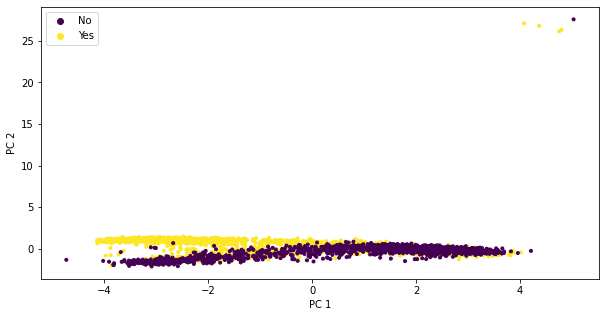

In [9]:
visualize_2pcas(X_train_pca, y_train)

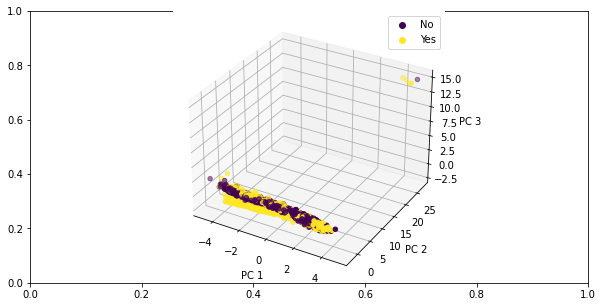

In [10]:
visualize_3pcas(X_train_pca, y_train)

Evaluation on full data

In [11]:
train_predict(X_train, y_train, X_test, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.935644,0.909320,0.957560,0.932817
svc,0.936881,0.926952,0.943590,0.935197
xgb,0.938119,0.916877,0.955381,0.935733


Evaluation on reduced data

In [12]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.931931,0.904282,0.954787,0.928849
svc,0.931931,0.901763,0.957219,0.928664
xgb,0.930693,0.891688,0.964578,0.926702


In [21]:
scores = []
for preds in [lr_preds, svc_preds, xgb_preds]:
    scores.append(
        [
            accuracy_score(y_test, preds),
            recall_score(y_test, preds),
            precision_score(y_test, preds),
            f1_score(y_test, preds),
        ]
    )

pd.DataFrame(
    scores, columns=["acc", "recall", "precision", "f1"], index=["lr", "svc", "xgb"]
)

,acc,recall,precision,f1
lr,0.935644,0.909320,0.957560,0.932817
svc,0.936881,0.926952,0.943590,0.935197
xgb,0.938119,0.916877,0.955381,0.935733
